# Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import csv
import re
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Data dictionary

* Date - Date of the crash

* Time - Time of the crash

* Location - Location of the crash
 
* Operator - Airline of the plane

* Route - Route taken by plane

* Type - Type of the plane

* Aboard - Number of people aboard

* Fatalities - Number of lethal outcomes

* Ground - Total people killed due to crash on the ground (for example, those who were not on board, but died due to the crash)

* Summary - Brief summary of the case

# Data preparation

In [2]:
data = pd.read_csv('Airplane_Crashes_and_Fatalities_Since_1908.csv')

In [3]:
data.drop(['Flight #', 'Registration', 'cn/In'], axis=1, inplace=True)

In [4]:
times = []
for i in range(data.shape[0]):
    try:
        times.append(int(data['Time'][i][0:2]))
    except:
        continue

data_hours = pd.DataFrame()
data_hours['Time'] = pd.Series(times)
data['Time'] = data_hours['Time']

In [5]:
def drop_missing_data_rows(data: pd.DataFrame):
    missing_data_rows = pd.isna(data["Date"])
    return data.drop(data[missing_data_rows].index, axis=0)

In [6]:
def convert_float_to_int (data: pd.DataFrame):
    columns = data.select_dtypes(include=['float64']).columns
    data[columns] = data[columns].apply(pd.to_numeric, downcast='integer', errors='coerce')
    return data

In [7]:
data = drop_missing_data_rows(data)
data = convert_float_to_int(data)

In [8]:
data['Location'].fillna("Unknown", inplace=True)
data['Operator'].fillna("Unknown", inplace=True)
data['Route'].fillna("Unknown", inplace=True)
data['Type'].fillna("Unknown", inplace=True)
data['Summary'].fillna("Unknown", inplace=True)

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = pd.DatetimeIndex(data['Date'])
date_index = data.set_index('Date')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5268 entries, 0 to 5267
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        5268 non-null   datetime64[ns]
 1   Time        3035 non-null   float64       
 2   Location    5268 non-null   object        
 3   Operator    5268 non-null   object        
 4   Route       5268 non-null   object        
 5   Type        5268 non-null   object        
 6   Aboard      5246 non-null   float64       
 7   Fatalities  5256 non-null   float64       
 8   Ground      5246 non-null   float64       
 9   Summary     5268 non-null   object        
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 452.7+ KB


In [11]:
data.describe()

,Time,Aboard,Fatalities,Ground
count,3035.000000,5246.000000,5256.000000,5246.000000
mean,12.869522,27.554518,20.068303,1.608845
std,6.018657,43.076711,33.199952,53.987827
min,0.000000,0.000000,0.000000,0.000000
25%,9.000000,5.000000,3.000000,0.000000
50%,13.000000,13.000000,9.000000,0.000000
75%,18.000000,30.000000,23.000000,0.000000
max,23.000000,644.000000,583.000000,2750.000000


In [12]:
data.shape

(5268, 10)

In [13]:
data.isnull().sum()

Date             0
Time          2233
Location         0
Operator         0
Route            0
Type             0
Aboard          22
Fatalities      12
Ground          22
Summary          0
dtype: int64

In [14]:
data.head()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary
0,1908-09-17,17.0,"Fort Myer, Virginia",Military - U.S. Army,Demonstration,Wright Flyer III,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,1912-07-12,6.0,"AtlantiCity, New Jersey",Military - U.S. Navy,Test flight,Dirigible,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,1913-08-06,18.0,"Victoria, British Columbia, Canada",Private,Unknown,Curtiss seaplane,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,1913-09-09,10.0,Over the North Sea,Military - German Navy,Unknown,Zeppelin L-1 (airship),20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,1913-10-17,1.0,"Near Johannisthal, Germany",Military - German Navy,Unknown,Zeppelin L-2 (airship),30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...


In [15]:
data.tail()

,Date,Time,Location,Operator,Route,Type,Aboard,Fatalities,Ground,Summary
5263,2009-05-20,NaN,"Near Madiun, Indonesia",Military - Indonesian Air Force,Jakarta - Maduin,Lockheed C-130 Hercules,112.0,98.0,2.0,"While on approach, the military transport cras..."
5264,2009-05-26,NaN,"Near Isiro, DemocratiRepubliCongo",Service Air,Goma - Isiro,Antonov An-26,4.0,4.0,NaN,The cargo plane crashed while on approach to I...
5265,2009-06-01,NaN,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,Rio de Janeiro - Paris,Airbus A330-203,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...
5266,2009-06-07,NaN,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,1.0,1.0,0.0,The air ambulance crashed into hills while att...
5267,2009-06-08,NaN,"State of Arunachal Pradesh, India",Military - Indian Air Force,Mechuka for Jorhat,Antonov An-32,13.0,13.0,0.0,The military transport went missing while en r...


# Data analysis and visualization

## Count of crashes by Decade

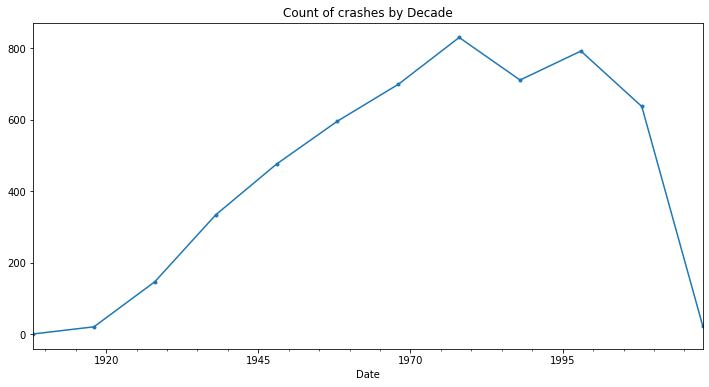

In [16]:
date_index.resample('10y').size().plot(figsize=[12, 6],
title='Count of crashes by Decade', marker=".")

## Count of crashes by Year

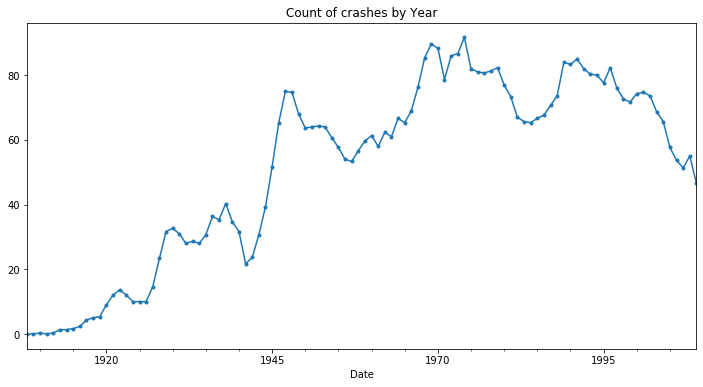

In [17]:
crashes_by_year = date_index.resample('1y').size().rolling(3).mean().fillna(0)
crashes_by_year.plot(figsize=[12, 6], title='Count of crashes by Year', marker=".")

## Count of crashes by Day of Week

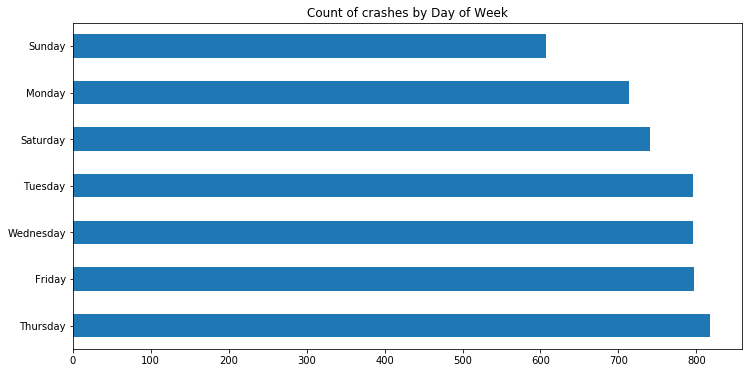

In [18]:
date_day = pd.DataFrame()
date_day = pd.Series(data['Date']).dt.day_name()
date_day.value_counts().plot(kind='barh', figsize=[12, 6], title='Count of crashes by Day of Week')

## Count of crashes by Month

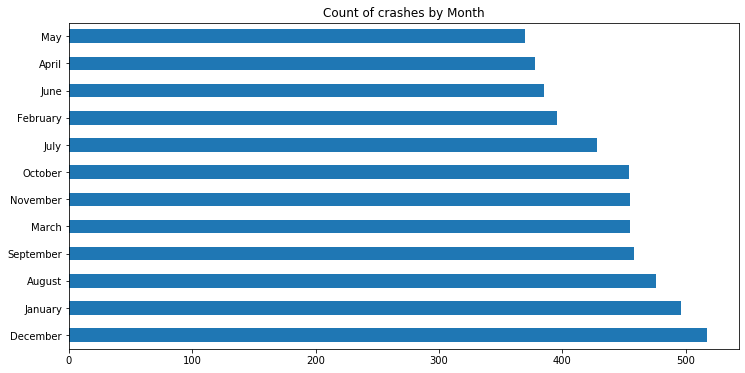

In [19]:
date_month = pd.DataFrame()
date_month.index.name = 'index'
date_month['Month'] = pd.Series(data['Date'])
date_month['Month'] = date_month['Month'].dt.month_name()
date_month['Month'].value_counts().plot(kind='barh',figsize=[12, 6], title='Count of crashes by Month')

## Count of crashes by Season

Date
winter    1409
autumn    1367
summer    1289
spring    1203
Name: Date, dtype: int64

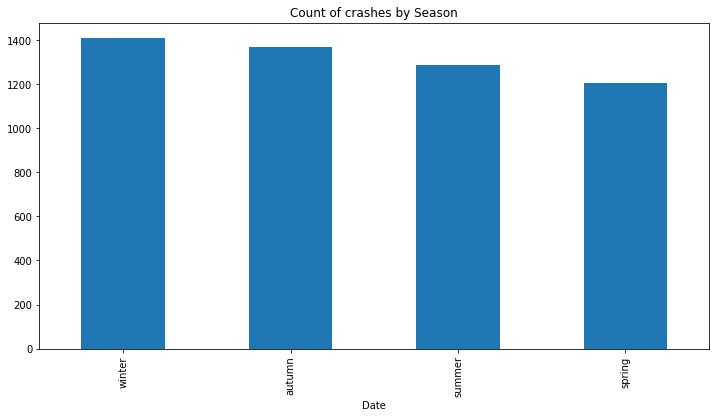

In [20]:
date_season = pd.DataFrame()
date_season = pd.Series(data['Date']).dt.month

def get_season(month):
    if month >= 3 and month <= 5:
        return 'spring'
    elif month >= 6 and month <= 8:
        return 'summer'
    elif month >= 9 and month <= 11:
        return 'autumn'
    else:
        return 'winter'

date_season = date_season.apply(get_season)

crashed_by_season = date_season.groupby(date_season).count().sort_values(ascending=False)
crashed_by_season.plot(kind='bar', figsize=[12, 6], title='Count of crashes by Season')
crashed_by_season

## How many people were on board in each Fatality

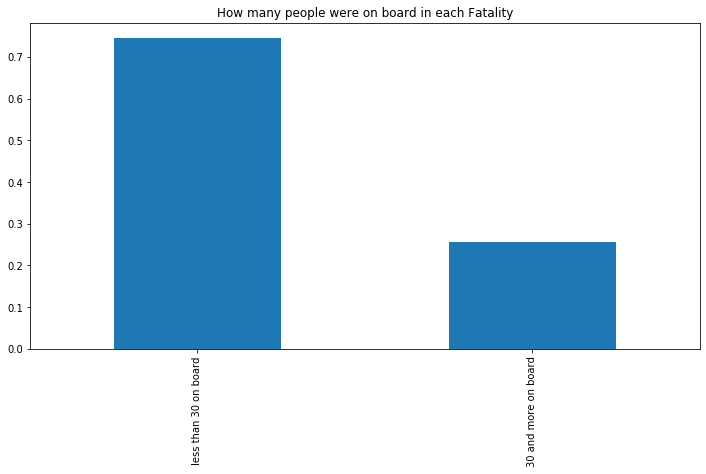

In [21]:
pd.Series(
    np.where(data['Aboard'] > 29,'30 and more on board','less than 30 on board')).value_counts(
    normalize = True).plot(kind='bar', figsize=[12, 6], title='How many people were on board in each Fatality')

## Count of hijacked planes crashed by year

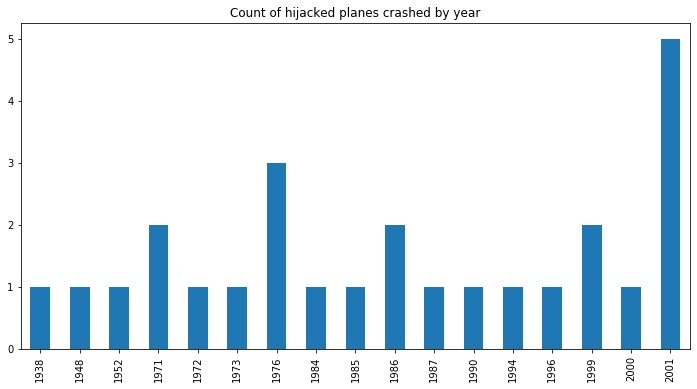

In [22]:
date_year = pd.DataFrame()
date_year['Year'] = pd.Series(data['Date']).dt.year
date_year['Summary'] = pd.Series(data['Summary'])
date_year[date_year['Summary'].str.contains('hijacke')]['Year'].value_counts().sort_index().plot(
kind='bar',figsize=[12, 6], title='Count of hijacked planes crashed by year')

## Count of missing planes by year

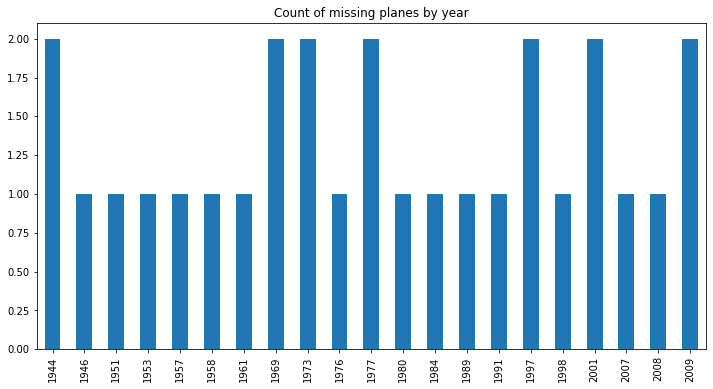

In [23]:
date_year['Year'] = pd.Series(data['Date']).dt.year
date_year['Summary'] = pd.Series(data['Summary'])
date_year[date_year['Summary'].str.contains('missing')]['Year'].value_counts().sort_index().plot(
kind='bar',figsize=[12, 6], title='Count of missing planes by year')

## Analysis of brazilian flights

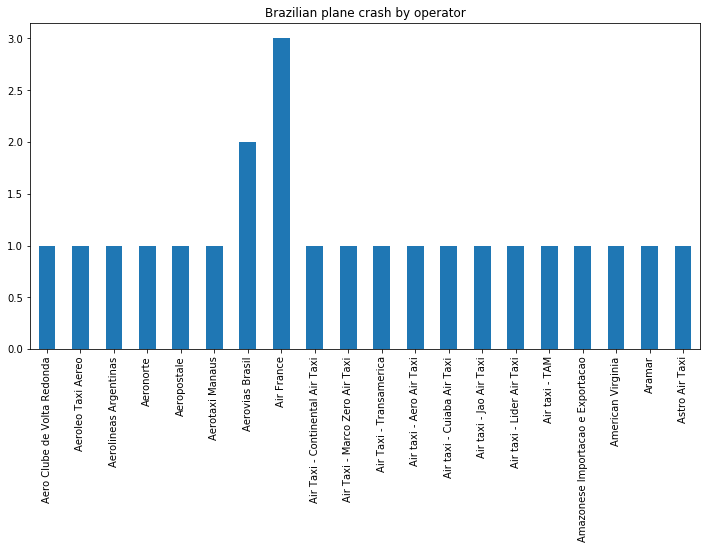

In [24]:
filter_br = data['Location'].str.contains('Brazil')
data[filter_br]['Operator'].value_counts().sort_index().head(20).plot(
kind='bar',figsize=[12, 6], title='Brazilian plane crash by operator')

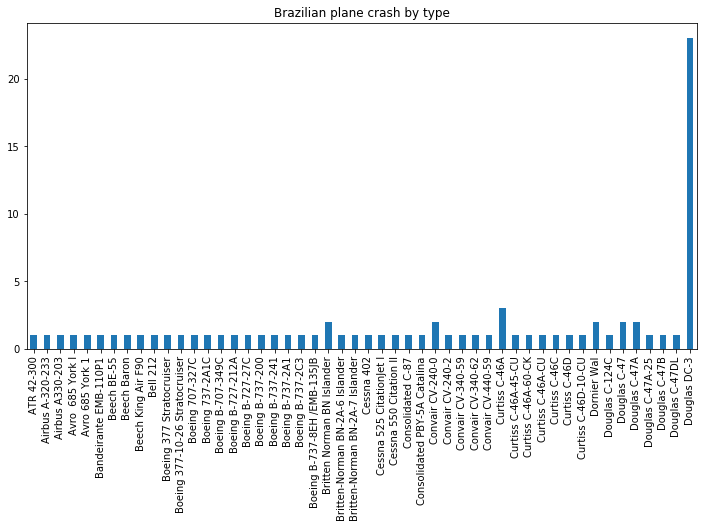

In [25]:
data[filter_br]['Type'].value_counts().sort_index().head(50).plot(
kind='bar',figsize=[12, 6], title='Brazilian plane crash by type')

## Time series analysis

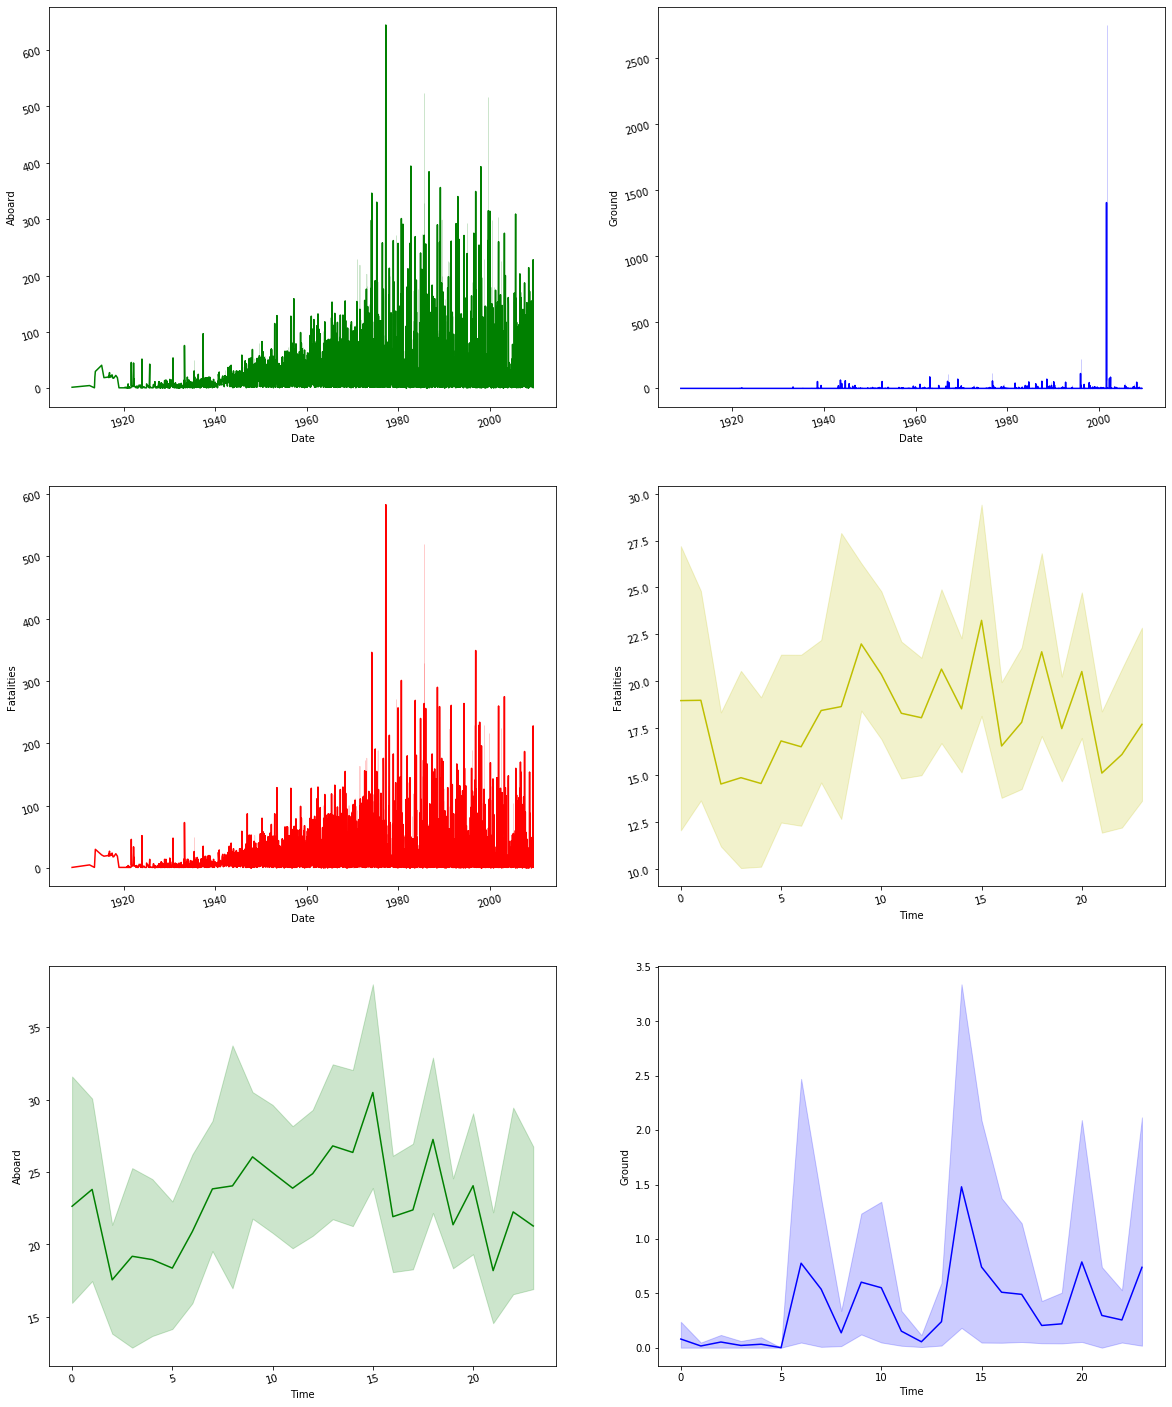

In [26]:
fig,ax = plt.subplots(3, 2, figsize = (20, 25))

sns.lineplot(x = "Date", y = "Aboard", color = 'g', data = data, ax = ax[0][0])

ax[0][0].tick_params(labelrotation = 15)
sns.lineplot( x = "Date", y = "Ground", color = 'b', data = data, ax = ax[0][1])

ax[0][1].tick_params(labelrotation = 15)
sns.lineplot(x = "Date", y = "Fatalities", color = 'r', data = data, ax = ax[1][0])

ax[1][0].tick_params(labelrotation = 15)
sns.lineplot(x = "Time", y = "Fatalities", color = 'y', data = data, ax = ax[1][1])

ax[1][1].tick_params(labelrotation = 15)
sns.lineplot(x = "Time", y = "Aboard", color = 'g', data = data, ax = ax[2][0])

ax[2][0].tick_params(labelrotation = 15)
sns.lineplot(x = "Time", y = "Ground", color = 'b', data = data, ax = ax[2][1])

plt.show()

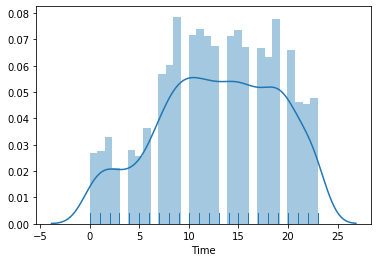

In [27]:
sns.distplot(data['Time'], hist=True, bins=30, rug=True, axlabel="Time")

## Plane crashes in WW1 and WWII

In [28]:
select = (date_year['Year'] >= 1914) & (date_year['Year'] <= 1918)
ww1 = pd.DataFrame()
ww1 = date_year[select]
ww1.head()

,Year,Summary
5,1915,Crashed into trees while attempting to land af...
6,1915,"Exploded and burned near Neuwerk Island, when..."
7,1916,"Crashed near the Black Sea, cause unknown."
8,1916,Shot down by British aircraft crashing in flames.
9,1916,Shot down in flames by the British 39th Home D...


In [29]:
select = (date_year['Year'] >= 1939) & (date_year['Year'] <= 1945)
ww2 = pd.DataFrame()
ww2 = date_year[select]
ww2.head()

,Year,Summary
503,1939,The aircraft crashed while attempting to land.
504,1939,"The aircraft crashed 2,650 feet past the runwa..."
505,1939,The seaplane crashed in flames in mountains no...
506,1939,Crashed into the Katherine River during a storm.
507,1939,"While en route, the aircraft ditched, broke in..."


In [30]:
ww_concat = pd.concat([ww1, ww2])
ww_concat.head()

,Year,Summary
5,1915,Crashed into trees while attempting to land af...
6,1915,"Exploded and burned near Neuwerk Island, when..."
7,1916,"Crashed near the Black Sea, cause unknown."
8,1916,Shot down by British aircraft crashing in flames.
9,1916,Shot down in flames by the British 39th Home D...


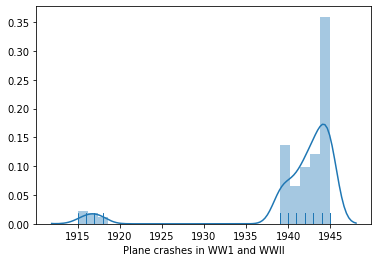

In [31]:
sns.distplot(ww_concat['Year'], hist=True, rug=True, axlabel="Plane crashes in WW1 and WWII")